# Equation Reader Model

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from google.colab import drive
from PIL import Image
import random
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.io import read_image
import torch.nn.functional as F

In [ ]:
# Load in data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Training and Test sets
test_classes = os.listdir('/content/drive/MyDrive/Test_1')
train_classes = os.listdir('/content/drive/MyDrive/Train_1')

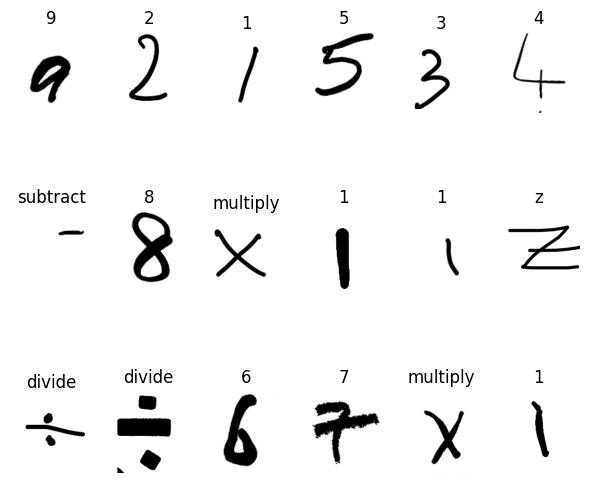

In [ ]:
# VIEWING AN IMAGE FROM EACH CLASS
# List to view random images
image_paths_train =[]
for cl in train_classes:
  temp = os.path.join('/content/drive/MyDrive/Train_1',cl)
  image_paths_train.append(temp)

random.shuffle(image_paths_train)
# Plot to random images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(6,6))
axes=axes.flatten()

for i, (image_path, ax) in enumerate(zip(image_paths_train[:18], axes)):
  image = mpimg.imread(image_path)
  ax.imshow(image,cmap='gray')
  ax.axis('off')
  ax.set_title(image_path[31:].split(' ', 1)[0])
plt.tight_layout()
plt.show()

## Dataset and Dataloaders

In [ ]:
train_path = '/content/drive/MyDrive/Train_1'
test_path = '/content/drive/MyDrive/Test_1'

class_dict = {
    "0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9,"add":10,"subtract":11,"multiply":12,"divide":13,"point":14,
    "equals":15,"y":16,"z":17
}

In [ ]:
class MathSymbolDataset(Dataset):
  def __init__(self, root_dir, transforms=None):
    self.root_dir = root_dir
    self.transforms = transforms
    self.files = os.listdir(root_dir)

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.files[index])
    image = Image.open(img_path)

    class_name = img_path.split('/')[-1]
    label_key = class_name.split(' ')[0]
    label = class_dict[label_key]

    if self.transforms:
      for t in self.transforms:
        image = t(image)

    return(image,torch.tensor(label))

In [ ]:
train = MathSymbolDataset(train_path,transforms=[T.Resize((150,150)),T.Grayscale(),T.ToTensor()])
test = MathSymbolDataset(test_path,transforms=[T.Resize((150,150)),T.Grayscale(),T.ToTensor()])

In [ ]:
from torch.utils.data import DataLoader as DL

In [ ]:
batch_size = 256
train_DL = DL(dataset=train, batch_size=batch_size, shuffle=True)
test_DL = DL(dataset=test, batch_size=batch_size, shuffle=True)

# Model

In [ ]:
class MathModel(nn.Module):
  def __init__(self):
    super(MathModel,self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1)
    self.mp = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
    self.lin = nn.Linear(64 * 37 * 37, 128)
    self.lin2 = nn.Linear(128, 18)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.mp(x)
    x = F.relu(self.conv2(x))
    x = self.mp(x)
    x = F.relu(self.conv3(x))
    x = x.view(-1, 64 * 37 * 37)
    x = self.lin(x)
    x = self.lin2(x)

    return x

model = MathModel()
print(model)

MathModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin): Linear(in_features=87616, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=18, bias=True)
)


# Train Test Loop

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.5 MB/s eta 0:00:00


In [ ]:
import torchmetrics
# Loss, Optimizer, and Accuracy metric
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes = 18)

In [ ]:
from tqdm.auto import tqdm
num_epochs = 7

for epoch in tqdm(range(num_epochs)):
  model.train()
  train_loss, running_loss, accuracy_train = 0, 0, 0

  for i, data in tqdm(enumerate(train_DL)):
    input, x_label = data

    # Make prediction
    x_pred = model(input)

    # Loss function and accumulate loss
    loss = loss_fn(x_pred, x_label)
    train_loss += loss
    running_loss += loss
    # Optimizer zero grad
    optimizer.zero_grad()

    # Backprop
    loss.backward()

    # Optimizer step
    optimizer.step()
    accuracy_train += accuracy(x_pred, x_label)
    if i % 10 == 9:
            print(f"[{epoch + 1}, {i + 1}] Loss: {running_loss / 10:.3f}")
            running_loss = 0.0

  train_loss /= len(train_DL)
  accuracy_train /= len(train_DL)
    ### Testing
  test_loss, accuracy_test = 0, 0
  model.eval()

  with torch.inference_mode():
    for inp, y_label in tqdm(test_DL):
      # Forward pass
      y_pred = model(inp)

      # Loss
      test_loss += loss_fn(y_pred, y_label)
      accuracy_test += accuracy(y_pred, y_label)
    test_loss /= len(test_DL)
    accuracy_test /= len(test_DL)
  print(f"\nTrain Loss: {train_loss:.4f} | Train Accuracy: {accuracy_train:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy_test:.4f}")

print("Finished")

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[1, 10] Loss: 3.348
[1, 20] Loss: 2.329
[1, 30] Loss: 1.573
[1, 40] Loss: 1.358
[1, 50] Loss: 1.151
[1, 60] Loss: 0.946
[1, 70] Loss: 0.915
[1, 80] Loss: 0.786
[1, 90] Loss: 0.695
[1, 100] Loss: 0.629
[1, 110] Loss: 0.593
[1, 120] Loss: 0.552
[1, 130] Loss: 0.515
[1, 140] Loss: 0.502
[1, 150] Loss: 0.437
[1, 160] Loss: 0.459
[1, 170] Loss: 0.495
[1, 180] Loss: 0.442
[1, 190] Loss: 0.405


  0%|          | 0/50 [00:00<?, ?it/s]


Train Loss: 0.9364 | Train Accuracy: 0.6761 | Test Loss: 0.4018 | Test Accuracy: 0.8553


0it [00:00, ?it/s]

[2, 10] Loss: 0.339
[2, 20] Loss: 0.398
[2, 30] Loss: 0.322
[2, 40] Loss: 0.354
[2, 50] Loss: 0.331
[2, 60] Loss: 0.312
[2, 70] Loss: 0.317
[2, 80] Loss: 0.342
[2, 90] Loss: 0.278
[2, 100] Loss: 0.325
[2, 110] Loss: 0.336
[2, 120] Loss: 0.309
[2, 130] Loss: 0.282
[2, 140] Loss: 0.313
[2, 150] Loss: 0.339
[2, 160] Loss: 0.306
[2, 170] Loss: 0.308
[2, 180] Loss: 0.323
[2, 190] Loss: 0.331


  0%|          | 0/50 [00:00<?, ?it/s]


Train Loss: 0.3240 | Train Accuracy: 0.8871 | Test Loss: 0.3019 | Test Accuracy: 0.8823


0it [00:00, ?it/s]

[3, 10] Loss: 0.225
[3, 20] Loss: 0.207
[3, 30] Loss: 0.247
[3, 40] Loss: 0.207
[3, 50] Loss: 0.235
[3, 60] Loss: 0.211
[3, 70] Loss: 0.223
[3, 80] Loss: 0.234
[3, 90] Loss: 0.220
[3, 100] Loss: 0.252
[3, 110] Loss: 0.216
[3, 120] Loss: 0.205
[3, 130] Loss: 0.217
[3, 140] Loss: 0.209
[3, 150] Loss: 0.220
[3, 160] Loss: 0.206
[3, 170] Loss: 0.223
[3, 180] Loss: 0.220
[3, 190] Loss: 0.250


  0%|          | 0/50 [00:00<?, ?it/s]


Train Loss: 0.2222 | Train Accuracy: 0.9258 | Test Loss: 0.2621 | Test Accuracy: 0.9086


0it [00:00, ?it/s]

[4, 10] Loss: 0.166
[4, 20] Loss: 0.146
[4, 30] Loss: 0.136
[4, 40] Loss: 0.156
[4, 50] Loss: 0.157
[4, 60] Loss: 0.159
[4, 70] Loss: 0.131
[4, 80] Loss: 0.129
[4, 90] Loss: 0.158
[4, 100] Loss: 0.146
[4, 110] Loss: 0.132
[4, 120] Loss: 0.166
[4, 130] Loss: 0.151
[4, 140] Loss: 0.147
[4, 150] Loss: 0.140
[4, 160] Loss: 0.133
[4, 170] Loss: 0.147
[4, 180] Loss: 0.159
[4, 190] Loss: 0.137


  0%|          | 0/50 [00:00<?, ?it/s]


Train Loss: 0.1467 | Train Accuracy: 0.9530 | Test Loss: 0.2334 | Test Accuracy: 0.9112


0it [00:00, ?it/s]

[5, 10] Loss: 0.087
[5, 20] Loss: 0.102
[5, 30] Loss: 0.075
[5, 40] Loss: 0.095
[5, 50] Loss: 0.103
[5, 60] Loss: 0.083
[5, 70] Loss: 0.079
[5, 80] Loss: 0.087
[5, 90] Loss: 0.098
[5, 100] Loss: 0.107
[5, 110] Loss: 0.078
[5, 120] Loss: 0.072
[5, 130] Loss: 0.109
[5, 140] Loss: 0.106
[5, 150] Loss: 0.098
[5, 160] Loss: 0.113
[5, 170] Loss: 0.101
[5, 180] Loss: 0.091
[5, 190] Loss: 0.103


  0%|          | 0/50 [00:00<?, ?it/s]


Train Loss: 0.0942 | Train Accuracy: 0.9701 | Test Loss: 0.2432 | Test Accuracy: 0.9114


0it [00:00, ?it/s]

[6, 10] Loss: 0.052
[6, 20] Loss: 0.053
[6, 30] Loss: 0.054
[6, 40] Loss: 0.058
[6, 50] Loss: 0.041
[6, 60] Loss: 0.042
[6, 70] Loss: 0.048
[6, 80] Loss: 0.056
[6, 90] Loss: 0.047
[6, 100] Loss: 0.052
[6, 110] Loss: 0.046
[6, 120] Loss: 0.052
[6, 130] Loss: 0.063
[6, 140] Loss: 0.054
[6, 150] Loss: 0.056
[6, 160] Loss: 0.036
[6, 170] Loss: 0.066
[6, 180] Loss: 0.191
[6, 190] Loss: 0.146


  0%|          | 0/50 [00:00<?, ?it/s]


Train Loss: 0.0655 | Train Accuracy: 0.9780 | Test Loss: 0.2720 | Test Accuracy: 0.8987


0it [00:00, ?it/s]

[7, 10] Loss: 0.070
[7, 20] Loss: 0.060
[7, 30] Loss: 0.046
[7, 40] Loss: 0.051
[7, 50] Loss: 0.036
[7, 60] Loss: 0.047
[7, 70] Loss: 0.055
[7, 80] Loss: 0.050
[7, 90] Loss: 0.042
[7, 100] Loss: 0.042
[7, 110] Loss: 0.037
[7, 120] Loss: 0.035
[7, 130] Loss: 0.038
[7, 140] Loss: 0.039
[7, 150] Loss: 0.049
[7, 160] Loss: 0.058
[7, 170] Loss: 0.041
[7, 180] Loss: 0.044
[7, 190] Loss: 0.034


  0%|          | 0/50 [00:00<?, ?it/s]


Train Loss: 0.0465 | Train Accuracy: 0.9861 | Test Loss: 0.2511 | Test Accuracy: 0.9259
Finished


# Saving Model

In [ ]:
torch.save(model, '/content/drive/MyDrive/equation_reader_v1.pth')